In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns

from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import make_forecasting_frame
from sklearn.ensemble import AdaBoostRegressor
from tsfresh.utilities.dataframe_functions import impute

import warnings
warnings.filterwarnings('ignore')

C:\Users\au00681\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Construct the signal

Just for showing how the forecasting works, we invent our own signal here, that we want to forecast later.
It is a mixture of random noise and some sinus graph with a positive and negative slope.

In [18]:
x_up = np.arange(100)*0.1 + np.sin(30*np.pi*np.linspace(0, 1, 100)) + np.random.normal(scale=0.7,size=100)
x_down = np.arange(100, 0, -1)*0.15 + np.sin(30*np.pi*np.linspace(0, 1, 100)) + np.random.normal(scale=0.7,size=100)
x = np.concatenate([x_up, x_down])
x = pd.Series(data=x, index=pd.date_range('1/1/2011', periods=len(x), freq='H'))
x.head()

2011-01-01 00:00:00    0.265713
2011-01-01 01:00:00    0.372041
2011-01-01 02:00:00    1.490552
2011-01-01 03:00:00    0.070519
2011-01-01 04:00:00   -0.264392
Freq: H, dtype: float64

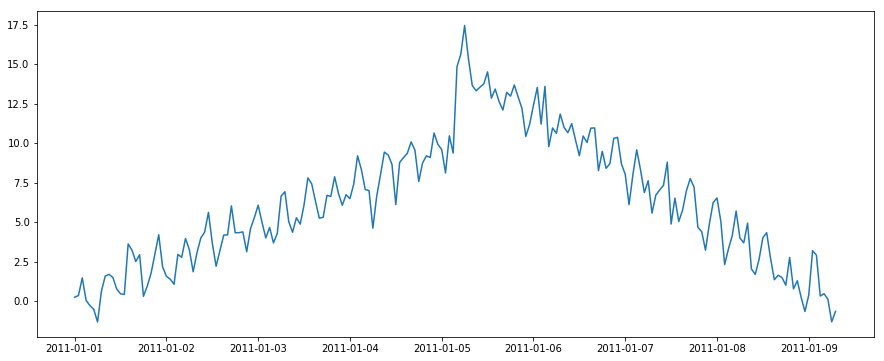

In [19]:
plt.figure(figsize=(15, 6))
plt.plot(x)
plt.show()

So, we have a time series and want to construct a time series model that is able to predict the next data points.

To do that, we have to construct a feature matrix by calculating the features for sub time series (see the forecasting section in the tsfresh documentation).

In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
df = pd.DataFrame(x)
df.reset_index(inplace=True)
df.columns = ["time", "value"]
df["kind"] = "a"
df["id"] = 1

In [23]:
len(df)

200

In [24]:
df.head(10)

,time,value,kind,id
0,2011-01-01 00:00:00,0.265713,a,1
1,2011-01-01 01:00:00,0.372041,a,1
2,2011-01-01 02:00:00,1.490552,a,1
3,2011-01-01 03:00:00,0.070519,a,1
4,2011-01-01 04:00:00,-0.264392,a,1
5,2011-01-01 05:00:00,-0.497571,a,1
6,2011-01-01 06:00:00,-1.298387,a,1
7,2011-01-01 07:00:00,0.641126,a,1
8,2011-01-01 08:00:00,1.598901,a,1
9,2011-01-01 09:00:00,1.712027,a,1


In [9]:
from tsfresh.utilities.dataframe_functions import roll_time_series

In [32]:
x.head()

2011-01-01 00:00:00    0.265713
2011-01-01 01:00:00    0.372041
2011-01-01 02:00:00    1.490552
2011-01-01 03:00:00    0.070519
2011-01-01 04:00:00   -0.264392
Freq: H, dtype: float64

In [31]:
df_shift, y = make_forecasting_frame(x, kind="price", max_timeshift=10, rolling_direction=1)

In [26]:
len(df_shift), len(y)

(1945, 199)

In [27]:
y.head(10)

2011-01-01 01:00:00    0.372041
2011-01-01 02:00:00    1.490552
2011-01-01 03:00:00    0.070519
2011-01-01 04:00:00   -0.264392
2011-01-01 05:00:00   -0.497571
2011-01-01 06:00:00   -1.298387
2011-01-01 07:00:00    0.641126
2011-01-01 08:00:00    1.598901
2011-01-01 09:00:00    1.712027
2011-01-01 10:00:00    1.515555
Freq: H, Name: value, dtype: float64

In [28]:
df_shift.head(10)

,time,value,id,kind
1746,2011-01-01 00:00:00,0.265713,2011-01-01 01:00:00,price
1548,2011-01-01 00:00:00,0.265713,2011-01-01 02:00:00,price
1747,2011-01-01 01:00:00,0.372041,2011-01-01 02:00:00,price
1351,2011-01-01 00:00:00,0.265713,2011-01-01 03:00:00,price
1549,2011-01-01 01:00:00,0.372041,2011-01-01 03:00:00,price
1748,2011-01-01 02:00:00,1.490552,2011-01-01 03:00:00,price
1155,2011-01-01 00:00:00,0.265713,2011-01-01 04:00:00,price
1352,2011-01-01 01:00:00,0.372041,2011-01-01 04:00:00,price
1550,2011-01-01 02:00:00,1.490552,2011-01-01 04:00:00,price
1749,2011-01-01 03:00:00,0.070519,2011-01-01 04:00:00,price


`df_shift` is ready to be passed into the feature extraction process in tsfresh 

In [34]:
X = extract_features(df_shift, column_id="id", column_sort="time", column_value="value", impute_function=impute, 
                     show_warnings=False)

Feature Extraction: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:33<00:00,  3.35s/it]
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_10__attr_"intercept"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_10__attr_"rvalue"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_10__attr_"slope"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_10__attr_"stderr"'
 'value__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"'

 'value__spkt_welch_density__coeff_8'] did not have any finite values. Filling with zeros.


In [35]:
X.head()

variable,value__abs_energy,value__absolute_sum_of_changes,"value__agg_autocorrelation__f_agg_""mean""","value__agg_autocorrelation__f_agg_""median""","value__agg_autocorrelation__f_agg_""var""","value__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""intercept""","value__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""rvalue""","value__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""slope""","value__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""stderr""","value__agg_linear_trend__f_agg_""max""__chunk_len_50__attr_""intercept""",...,value__time_reversal_asymmetry_statistic__lag_1,value__time_reversal_asymmetry_statistic__lag_2,value__time_reversal_asymmetry_statistic__lag_3,value__value_count__value_-inf,value__value_count__value_0,value__value_count__value_1,value__value_count__value_inf,value__value_count__value_nan,value__variance,value__variance_larger_than_standard_deviation
id,,,,,,,,,,,,,,,,,,,,,
2011-01-01 01:00:00,0.070604,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2011-01-01 02:00:00,0.209018,0.106327,-1.000000,-1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.002826,0.0
2011-01-01 03:00:00,2.430762,1.224838,-0.657287,-0.657287,0.222653,0.0,0.0,0.0,0.0,0.0,...,0.800312,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.306956,0.0
2011-01-01 04:00:00,2.435735,2.644871,-0.156610,-0.296747,0.197205,0.0,0.0,0.0,0.0,0.0,...,0.300705,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.306757,0.0
2011-01-01 05:00:00,2.505638,2.979782,-0.155868,-0.021944,0.154282,0.0,0.0,0.0,0.0,0.0,...,0.149888,-0.001044,0.0,0.0,0.0,0.0,0.0,0.0,0.351446,0.0


In [44]:
X.index

DatetimeIndex(['2011-01-01 01:00:00', '2011-01-01 02:00:00',
               '2011-01-01 03:00:00', '2011-01-01 04:00:00',
               '2011-01-01 05:00:00', '2011-01-01 06:00:00',
               '2011-01-01 07:00:00', '2011-01-01 08:00:00',
               '2011-01-01 09:00:00', '2011-01-01 10:00:00',
               ...
               '2011-01-08 22:00:00', '2011-01-08 23:00:00',
               '2011-01-09 00:00:00', '2011-01-09 01:00:00',
               '2011-01-09 02:00:00', '2011-01-09 03:00:00',
               '2011-01-09 04:00:00', '2011-01-09 05:00:00',
               '2011-01-09 06:00:00', '2011-01-09 07:00:00'],
              dtype='datetime64[ns]', name='id', length=199, freq=None)

In [36]:
len(X), len(y)

(199, 199)

In [37]:
y.head()

2011-01-01 01:00:00    0.372041
2011-01-01 02:00:00    1.490552
2011-01-01 03:00:00    0.070519
2011-01-01 04:00:00   -0.264392
2011-01-01 05:00:00   -0.497571
Freq: H, Name: value, dtype: float64

Here, the first row for `id=2011-01-01 01:00:00` contains features that were just calculate on `2011-01-01 00:00:00`. 
The third row `2011-01-01 03:00:00` contains features that were calculated on `2011-01-01 00:00:00`, `2011-01-01 01:00:00` and `2011-01-01 02:00:00`.

However, because we set `max_timeshift` to 10, the features will only be based on a maximum number of 10 historic data points.

We are now using the features, to train a normal AdaBoostRegressor to predict the next time step. So for every data point, we fit the model on all older data points, then predict the next data point. Then we fit it on all data points again plus that predicted data point and so on.

In [40]:
X.iloc[:1]

variable,value__abs_energy,value__absolute_sum_of_changes,"value__agg_autocorrelation__f_agg_""mean""","value__agg_autocorrelation__f_agg_""median""","value__agg_autocorrelation__f_agg_""var""","value__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""intercept""","value__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""rvalue""","value__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""slope""","value__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""stderr""","value__agg_linear_trend__f_agg_""max""__chunk_len_50__attr_""intercept""",...,value__time_reversal_asymmetry_statistic__lag_1,value__time_reversal_asymmetry_statistic__lag_2,value__time_reversal_asymmetry_statistic__lag_3,value__value_count__value_-inf,value__value_count__value_0,value__value_count__value_1,value__value_count__value_inf,value__value_count__value_nan,value__variance,value__variance_larger_than_standard_deviation
id,,,,,,,,,,,,,,,,,,,,,
2011-01-01 01:00:00,0.070604,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
y.iloc[:2]

2011-01-01 01:00:00    0.372041
2011-01-01 02:00:00    1.490552
Freq: H, Name: value, dtype: float64

In [49]:
y.iloc[0]

0.37204087481139492

In [53]:
X.iloc[1, :]

variable
value__abs_energy                                                        0.209018
value__absolute_sum_of_changes                                           0.106327
value__agg_autocorrelation__f_agg_"mean"                                -1.000000
value__agg_autocorrelation__f_agg_"median"                              -1.000000
value__agg_autocorrelation__f_agg_"var"                                  0.000000
value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"intercept"     0.000000
value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"rvalue"        0.000000
value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"slope"         0.000000
value__agg_linear_trend__f_agg_"max"__chunk_len_10__attr_"stderr"        0.000000
value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"intercept"     0.000000
value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"        0.000000
value__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"         0.000000
value__

In [55]:
ada = AdaBoostRegressor()

y_pred = [0] * len(y)
y_pred[0] = y.iloc[0]

for i in range(1, len(y)):
    ada.fit(X.iloc[:i], y[:i])
    y_pred[i] = ada.predict(X.iloc[i, :].reshape(1, -1))
    
y_pred = pd.Series(data=y_pred, index=y.index)

In [25]:
y_pred = pd.Series(data=y_pred, index=y.index)

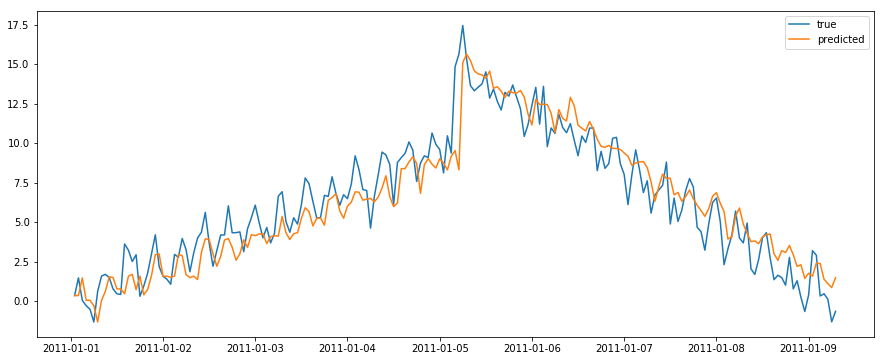

In [56]:
plt.figure(figsize=(15, 6))
plt.plot(y, label="true")
plt.plot(y_pred, label="predicted")
plt.legend()
plt.show()